
[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Packages loaded successfully!
Starting Streamlined Advanced Stock Prediction
Loading data...
Data shape: (2569, 39)
Engineering features...

Processing Stock 1
Data shape: X=(2499, 60, 208), y=(2499, 10)
Training TabNet...
epoch 0  | loss: 3.98859 | val_0_mse: 0.06064 |  0:00:03s
epoch 1  | loss: 1.68836 | val_0_mse: 0.06975 |  0:00:06s
epoch 2  | loss: 0.82715 | val_0_mse: 0.0088  |  0:00:08s
epoch 3  | loss: 0.4968  | val_0_mse: 0.02277 |  0:00:10s
epoch 4  | loss: 0.24033 | val_0_mse: 0.00732 |  0:00:13s
epoch 5  | loss: 0.12379 | val_0_mse: 0.00534 |  0:00:16s
epoch 6  | loss: 0.0566  | val_0_mse: 0.00247 |  0:00:18s
epoch 7  | loss: 0.02844 | val_0_mse: 0.00218 |  0:00:21s
epoch 8  | loss: 0.0113  | val_0_mse: 0.0011  |  0:00:23s
epoch 9  | loss: 0.00314 | val_0_mse: 0.00088 |  0:00:26s
epoch 10 | loss: 0.00174 | val_0_mse: 0.00329 |  0:00:29s
epoch 11 | loss: 0.00085 | val_0_mse: 0.00411 |  0:00:32s
epoch 12 | loss: 0.00067 | val_0_mse: 0.00324 |  0:00:35s
epoch 13 | loss: 0.0004

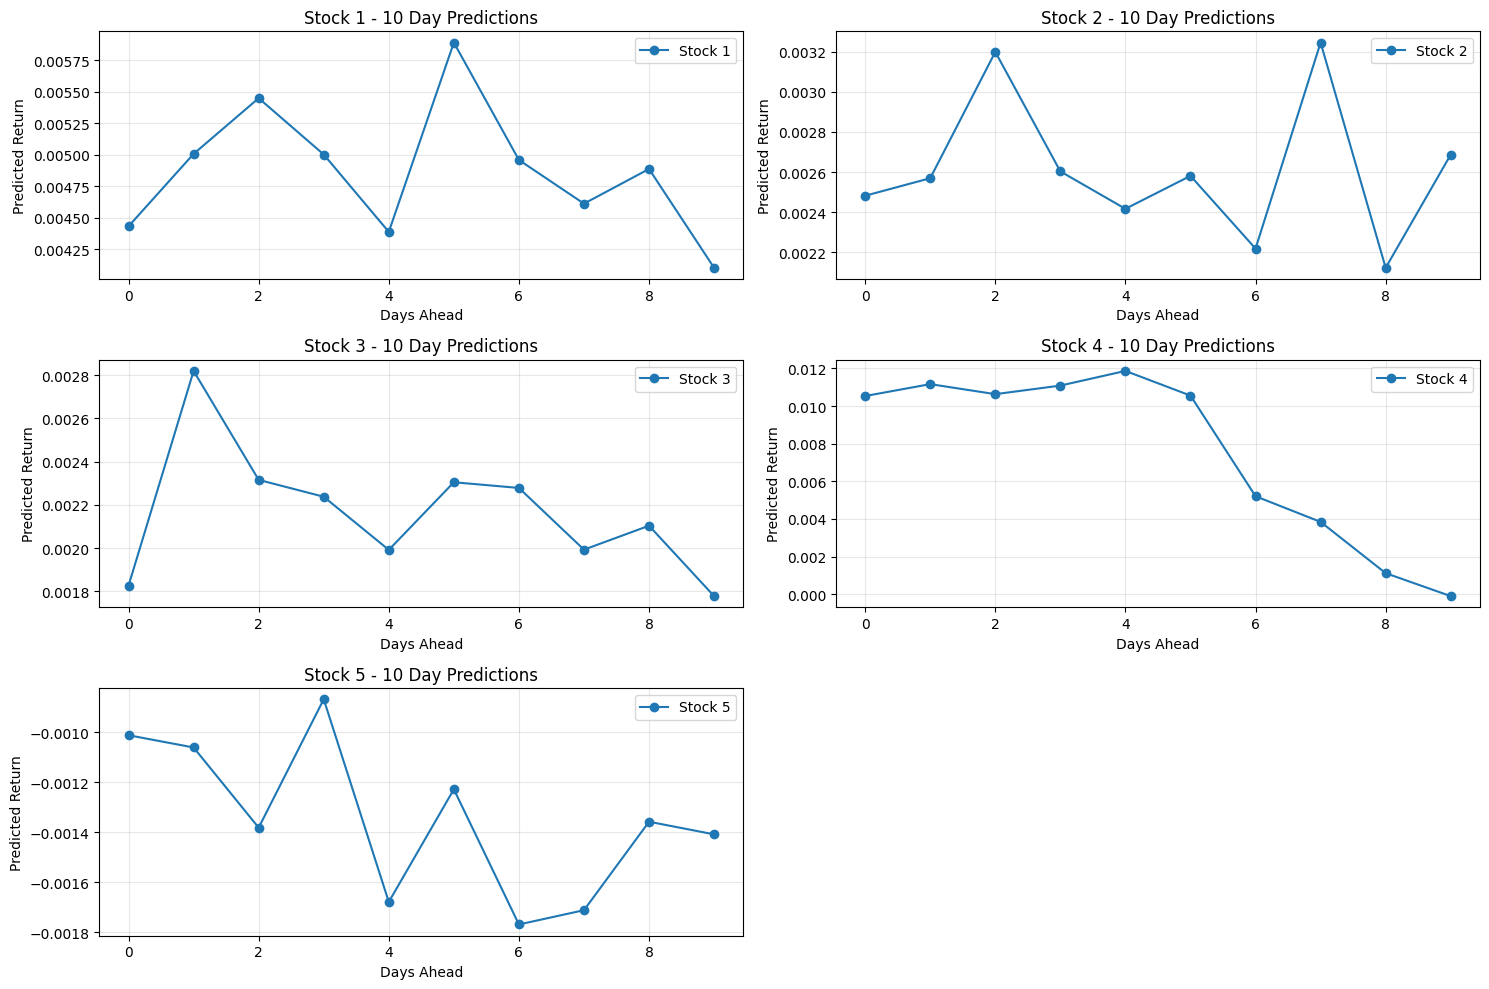


All done! Check 'streamlined_submission.csv' for results.


In [3]:
# Streamlined Advanced Stock Prediction
# Focused on TabNet, LightGBM, and Neural Networks

# Install core packages
!pip install -q pytorch-tabnet
!pip install -q lightgbm
!pip install -q ta
!pip install -q optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Core ML packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pytorch_tabnet.tab_model import TabNetRegressor
import optuna
import lightgbm as lgb
import ta
from datetime import datetime
import os

# Set seeds
np.random.seed(42)
torch.manual_seed(42)

print("Packages loaded successfully!")

# Enhanced LSTM model
class EnhancedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, dropout=0.2):
        super(EnhancedLSTM, self).__init__()
        
        # Multi-layer LSTM
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        
        # Attention layer
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        # Output layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 10)  # 10 days prediction
        )
        
    def forward(self, x):
        # LSTM forward
        lstm_out, _ = self.lstm(x)
        
        # Attention mechanism
        attention_weights = F.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attention_weights * lstm_out, dim=1)
        
        # Output
        output = self.fc(context)
        return output

# Custom dataset
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Main predictor class
class StreamlinedPredictor:
    def __init__(self):
        self.models = {}
        self.scalers = {}
        self.feature_names = None
        
    def load_data(self, data_path):
        """Load and merge all data"""
        print("Loading data...")
        
        # Load stock data
        dfs = []
        for i in range(1, 6):
            df = pd.read_csv(f"{data_path}/test/test_{i}.csv")
            df.columns = [col if col == 'Date' else f"{col.lower()}_{i}" for col in df.columns]
            dfs.append(df)
        
        # Merge all stocks
        merged = dfs[0]
        for df in dfs[1:]:
            merged = pd.merge(merged, df, on='Date', how='outer')
        
        # Load indices
        for idx_name, file_name in [('dj', 'Dow_Jones.csv'), ('nasdaq', 'NASDAQ.csv'), ('sp500', 'SP500.csv')]:
            idx_df = pd.read_csv(f"{data_path}/train/indices/{file_name}")
            idx_df = idx_df.rename(columns={'Returns': f'returns_{idx_name}'})
            merged = pd.merge(merged, idx_df[['Date', f'returns_{idx_name}']], on='Date', how='left')
        
        merged['Date'] = pd.to_datetime(merged['Date'])
        merged = merged.sort_values('Date').reset_index(drop=True)
        
        print(f"Data shape: {merged.shape}")
        return merged
    
    def engineer_features(self, df):
        """Create all features"""
        print("Engineering features...")
        
        # Basic features for each stock
        for i in range(1, 6):
            close_col = f'close_{i}'
            volume_col = f'volume_{i}'
            returns_col = f'returns_{i}'
            
            if close_col in df.columns:
                # Fill NaN
                df[close_col] = df[close_col].fillna(method='ffill').fillna(method='bfill')
                
                # Price features
                df[f'high_low_ratio_{i}'] = df[close_col].rolling(2).max() / df[close_col].rolling(2).min()
                df[f'price_position_{i}'] = (df[close_col] - df[close_col].rolling(20).min()) / (
                    df[close_col].rolling(20).max() - df[close_col].rolling(20).min()
                )
                
                # Moving averages
                for window in [5, 10, 20, 50]:
                    df[f'sma_{window}_{i}'] = ta.trend.sma_indicator(df[close_col], window=window)
                    df[f'price_to_sma_{window}_{i}'] = df[close_col] / df[f'sma_{window}_{i}']
                
                # EMA
                df[f'ema_12_{i}'] = ta.trend.ema_indicator(df[close_col], window=12)
                df[f'ema_26_{i}'] = ta.trend.ema_indicator(df[close_col], window=26)
                
                # MACD
                macd = ta.trend.MACD(df[close_col])
                df[f'macd_{i}'] = macd.macd()
                df[f'macd_signal_{i}'] = macd.macd_signal()
                df[f'macd_diff_{i}'] = macd.macd_diff()
                
                # RSI
                df[f'rsi_{i}'] = ta.momentum.RSIIndicator(df[close_col], window=14).rsi()
                
                # Bollinger Bands
                bb = ta.volatility.BollingerBands(df[close_col], window=20)
                df[f'bb_high_{i}'] = bb.bollinger_hband()
                df[f'bb_low_{i}'] = bb.bollinger_lband()
                df[f'bb_pct_{i}'] = bb.bollinger_pband()
                
                # ATR
                high = df[close_col].rolling(2).max()
                low = df[close_col].rolling(2).min()
                df[f'atr_{i}'] = ta.volatility.AverageTrueRange(high, low, df[close_col], window=14).average_true_range()
                
                # Volume features
                if volume_col in df.columns:
                    df[volume_col] = df[volume_col].fillna(method='ffill').fillna(0)
                    df[f'volume_ratio_{i}'] = df[volume_col] / df[volume_col].rolling(20).mean()
                    df[f'volume_trend_{i}'] = df[volume_col].rolling(5).mean() / df[volume_col].rolling(20).mean()
                
                # Returns features
                if returns_col in df.columns:
                    # Volatility
                    for window in [5, 10, 20]:
                        df[f'volatility_{window}_{i}'] = df[returns_col].rolling(window).std()
                        df[f'skew_{window}_{i}'] = df[returns_col].rolling(window).skew()
                        df[f'kurtosis_{window}_{i}'] = df[returns_col].rolling(window).kurt()
                    
                    # Momentum
                    df[f'momentum_5_{i}'] = df[close_col].pct_change(5)
                    df[f'momentum_20_{i}'] = df[close_col].pct_change(20)
        
        # Cross-stock features
        returns_cols = [f'returns_{i}' for i in range(1, 6) if f'returns_{i}' in df.columns]
        if len(returns_cols) > 1:
            # Correlation features
            for window in [20, 60]:
                corr_matrix = df[returns_cols].rolling(window).corr()
                df[f'avg_correlation_{window}'] = corr_matrix.mean().mean()
            
            # Dispersion
            df['returns_dispersion'] = df[returns_cols].std(axis=1)
            df['returns_mean'] = df[returns_cols].mean(axis=1)
        
        # Market features
        market_cols = ['returns_dj', 'returns_nasdaq', 'returns_sp500']
        market_cols = [col for col in market_cols if col in df.columns]
        
        if market_cols:
            df['market_returns'] = df[market_cols].mean(axis=1)
            df['market_volatility'] = df[market_cols].std(axis=1)
            
            # Beta to market
            for i in range(1, 6):
                if f'returns_{i}' in df.columns:
                    for market in ['nasdaq', 'sp500']:
                        if f'returns_{market}' in df.columns:
                            rolling_cov = df[[f'returns_{i}', f'returns_{market}']].rolling(20).cov()
                            cov = rolling_cov.xs(f'returns_{market}', level=1)[f'returns_{i}']
                            var = df[f'returns_{market}'].rolling(20).var()
                            df[f'beta_{i}_{market}'] = cov / var
        
        # Time features
        df['day_of_week'] = df['Date'].dt.dayofweek
        df['month'] = df['Date'].dt.month
        df['quarter'] = df['Date'].dt.quarter
        df['day_of_month'] = df['Date'].dt.day
        df['week_of_year'] = df['Date'].dt.isocalendar().week
        
        # Cyclical encoding
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        
        # Lag features
        for i in range(1, 6):
            if f'returns_{i}' in df.columns:
                for lag in [1, 2, 3, 5, 10, 20]:
                    df[f'returns_{i}_lag_{lag}'] = df[f'returns_{i}'].shift(lag)
                    
                # Cumulative returns
                df[f'cum_returns_5_{i}'] = df[f'returns_{i}'].rolling(5).sum()
                df[f'cum_returns_20_{i}'] = df[f'returns_{i}'].rolling(20).sum()
        
        return df
    
    def prepare_data(self, df, target_stock, seq_length=60):
        """Prepare sequences for a specific stock"""
        target_col = f'returns_{target_stock}'
        feature_cols = [col for col in df.columns if col not in ['Date'] and 
                       not col.startswith('returns_') or col == target_col]
        
        # Remove columns with too many NaN
        valid_cols = []
        for col in feature_cols:
            if df[col].isna().sum() / len(df) < 0.5:
                valid_cols.append(col)
        
        feature_cols = valid_cols
        self.feature_names = feature_cols
        
        # Fill NaN
        df_clean = df[feature_cols].fillna(method='ffill').fillna(0)
        
        # Create sequences
        X, y = [], []
        
        for i in range(seq_length, len(df_clean) - 10):
            X.append(df_clean.iloc[i-seq_length:i].values)
            
            # Next 10 days returns
            future_returns = df[target_col].iloc[i:i+10].values
            y.append(future_returns)
        
        X = np.array(X)
        y = np.array(y)
        
        # Remove samples with NaN in target
        valid_idx = ~np.isnan(y).any(axis=1)
        X = X[valid_idx]
        y = y[valid_idx]
        
        return X, y, feature_cols
    
    def train_tabnet(self, X_train, y_train, X_val, y_val):
        """Train TabNet model"""
        print("Training TabNet...")
        
        # Flatten sequences
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        X_val_flat = X_val.reshape(X_val.shape[0], -1)
        
        # Use mean of future returns as target
        y_train_mean = y_train.mean(axis=1).reshape(-1, 1)
        y_val_mean = y_val.mean(axis=1).reshape(-1, 1)
        
        # TabNet model
        model = TabNetRegressor(
            n_d=32,
            n_a=32,
            n_steps=5,
            gamma=1.5,
            lambda_sparse=1e-4,
            optimizer_fn=torch.optim.Adam,
            optimizer_params=dict(lr=2e-2),
            scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
            scheduler_params=dict(mode='min', patience=5, factor=0.5),
            mask_type='entmax',
            verbose=1,
            device_name='cuda' if torch.cuda.is_available() else 'cpu'
        )
        
        model.fit(
            X_train_flat, y_train_mean,
            eval_set=[(X_val_flat, y_val_mean)],
            max_epochs=100,
            patience=20,
            batch_size=256,
            virtual_batch_size=128
        )
        
        return model
    
    def train_lightgbm(self, X_train, y_train, X_val, y_val):
        """Train LightGBM model"""
        print("Training LightGBM...")
        
        # Flatten sequences
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        X_val_flat = X_val.reshape(X_val.shape[0], -1)
        
        # Train separate model for each prediction day
        models = []
        
        for day in range(10):
            print(f"Training for day {day+1}...")
            
            lgb_model = lgb.LGBMRegressor(
                n_estimators=2000,
                learning_rate=0.01,
                num_leaves=31,
                feature_fraction=0.8,
                bagging_fraction=0.8,
                bagging_freq=5,
                min_child_samples=20,
                reg_alpha=0.1,
                reg_lambda=0.1,
                verbose=-1,
                random_state=42 + day
            )
            
            lgb_model.fit(
                X_train_flat, y_train[:, day],
                eval_set=[(X_val_flat, y_val[:, day])],
                callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
            )
            
            models.append(lgb_model)
        
        return models
    
    def train_lstm(self, X_train, y_train, X_val, y_val):
        """Train LSTM model"""
        print("Training LSTM...")
        
        # Create datasets
        train_dataset = StockDataset(X_train, y_train)
        val_dataset = StockDataset(X_val, y_val)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        # Model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = EnhancedLSTM(input_size=X_train.shape[2]).to(device)
        
        # Training setup
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
        criterion = nn.MSELoss()
        
        best_val_loss = float('inf')
        best_model = None
        patience_counter = 0
        
        # Training loop
        for epoch in range(100):
            # Train
            model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                
                train_loss += loss.item()
            
            # Validate
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    val_loss += loss.item()
            
            val_loss /= len(val_loader)
            scheduler.step(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= 15:
                print(f"Early stopping at epoch {epoch}")
                break
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Val Loss: {val_loss:.6f}")
        
        # Load best model
        model.load_state_dict(best_model)
        
        return model
    
    def predict_ensemble(self, models, X_test, scaler):
        """Make ensemble predictions"""
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Scale test data
        X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1]))
        X_test_scaled = X_test_scaled.reshape(X_test.shape)
        
        predictions = []
        
        # TabNet prediction
        if 'tabnet' in models:
            X_flat = X_test_scaled.reshape(X_test_scaled.shape[0], -1)
            tabnet_pred = models['tabnet'].predict(X_flat)
            # Expand to 10 days
            tabnet_pred_full = np.repeat(tabnet_pred, 10, axis=1).reshape(-1, 10)
            predictions.append(tabnet_pred_full)
        
        # LightGBM predictions
        if 'lightgbm' in models:
            X_flat = X_test_scaled.reshape(X_test_scaled.shape[0], -1)
            lgb_preds = []
            for day_model in models['lightgbm']:
                day_pred = day_model.predict(X_flat)
                lgb_preds.append(day_pred)
            lgb_pred_full = np.column_stack(lgb_preds)
            predictions.append(lgb_pred_full)
        
        # LSTM prediction
        if 'lstm' in models:
            models['lstm'].eval()
            with torch.no_grad():
                X_tensor = torch.FloatTensor(X_test_scaled).to(device)
                lstm_pred = models['lstm'](X_tensor).cpu().numpy()
            predictions.append(lstm_pred)
        
        # Ensemble (weighted average)
        if predictions:
            # Weights based on model performance (you can adjust these)
            weights = [0.3, 0.4, 0.3][:len(predictions)]
            weights = np.array(weights) / np.sum(weights)
            
            ensemble_pred = np.zeros_like(predictions[0])
            for i, pred in enumerate(predictions):
                ensemble_pred += weights[i] * pred
            
            return ensemble_pred
        else:
            return np.zeros((X_test.shape[0], 10))
    
    def run_pipeline(self, data_path):
        """Run complete pipeline"""
        print("="*50)
        print("Starting Streamlined Advanced Stock Prediction")
        print("="*50)
        
        # Load data
        df = self.load_data(data_path)
        
        # Engineer features
        df = self.engineer_features(df)
        
        # Prepare submission
        sample_submission = pd.read_csv(f'{data_path}/sample_submission.csv')
        submission_df = pd.DataFrame()
        submission_df['Date'] = sample_submission['Date'][:10]
        
        # Train model for each stock
        for stock_num in range(1, 6):
            print(f"\n{'='*50}")
            print(f"Processing Stock {stock_num}")
            print(f"{'='*50}")
            
            # Prepare data
            X, y, feature_names = self.prepare_data(df, stock_num)
            
            if len(X) == 0:
                print(f"No valid data for stock {stock_num}, using zeros")
                submission_df[f'return_{stock_num}'] = np.zeros(10)
                continue
            
            print(f"Data shape: X={X.shape}, y={y.shape}")
            
            # Split data
            split_idx = int(0.8 * len(X))
            X_train, X_val = X[:split_idx], X[split_idx:]
            y_train, y_val = y[:split_idx], y[split_idx:]
            
            # Scale features
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1]))
            X_train_scaled = X_train_scaled.reshape(X_train.shape)
            
            X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1]))
            X_val_scaled = X_val_scaled.reshape(X_val.shape)
            
            # Train models
            stock_models = {}
            
            try:
                # TabNet
                tabnet_model = self.train_tabnet(X_train_scaled, y_train, X_val_scaled, y_val)
                stock_models['tabnet'] = tabnet_model
            except Exception as e:
                print(f"TabNet training failed: {e}")
            
            try:
                # LightGBM
                lgb_models = self.train_lightgbm(X_train_scaled, y_train, X_val_scaled, y_val)
                stock_models['lightgbm'] = lgb_models
            except Exception as e:
                print(f"LightGBM training failed: {e}")
            
            try:
                # LSTM
                lstm_model = self.train_lstm(X_train_scaled, y_train, X_val_scaled, y_val)
                stock_models['lstm'] = lstm_model
            except Exception as e:
                print(f"LSTM training failed: {e}")
            
            # Store models
            self.models[f'stock_{stock_num}'] = stock_models
            self.scalers[f'stock_{stock_num}'] = scaler
            
            # Make predictions
            X_test = X[-1:] if len(X) > 0 else X_val[-1:]
            predictions = self.predict_ensemble(stock_models, X_test, scaler)
            
            # Add to submission
            submission_df[f'return_{stock_num}'] = predictions[0]
            
            print(f"Stock {stock_num} predictions: {predictions[0]}")
        
        # Save submission
        submission_df.to_csv('streamlined_submission.csv', index=False)
        
        print("\n" + "="*50)
        print("Prediction completed!")
        print("="*50)
        print("\nSubmission preview:")
        print(submission_df)
        
        # Plot predictions
        plt.figure(figsize=(15, 10))
        for i in range(1, 6):
            plt.subplot(3, 2, i)
            if f'return_{i}' in submission_df.columns:
                plt.plot(range(10), submission_df[f'return_{i}'].values, 'o-', label=f'Stock {i}')
                plt.xlabel('Days Ahead')
                plt.ylabel('Predicted Return')
                plt.title(f'Stock {i} - 10 Day Predictions')
                plt.grid(True, alpha=0.3)
                plt.legend()
        
        plt.tight_layout()
        plt.savefig('predictions_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return submission_df

# Run the pipeline
if __name__ == "__main__":
    # Set your data path
    DATA_PATH = "./input/stock-price-prediction-challenge"
    
    predictor = StreamlinedPredictor()
    submission = predictor.run_pipeline(DATA_PATH)
    
    print("\nAll done! Check 'streamlined_submission.csv' for results.")